In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tellurium as te

## Functions

In [2]:
# Load file and convert to SBML
# If file is in SBML, function will still load the model

def load_model(filename, filetype): 
    """ 
    filename: .txt, .csv, biomodels website
    filetype: ant, sbml
    
    Input the filename/path of the file and its syntax.
    Output declares whether file was successfully loaded or not.
    
    """
    model_ant = filename
    # Opens the file in "read mode"
    with open(model_ant, "r") as file:
        model_content = file.read()
    # If the file type is in antimony, convert to SBML and load the model into tellurium
    if filetype=='antimony':
        try:
            model_sbml = te.antimonyToSBML(model_content)
            loaded_model = te.loadSBMLModel(model_sbml)
            print(f"Successfully converted file '{filename}' from {filetype} to SBML and loaded.")
        except Exception as e:
            print("Could not load file.", e)
    # Else, assume model is SBML and load it into tellurium without converting
    else: 
        try:
            loaded_model = te.loadSBMLModel(model_content)
            print(f"Successfully loaded SBML file {filename}.")
        except Exception as e:
            print("Could not load SBML file.", e)
            
    return loaded_model

In [3]:
def simulate_model(load_model, t0, t1, steps):
    '''
    loaded_model: class 'tellurium.roadrunner.extended_roadrunner.ExtendedRoadRunner'
    t0: int
    t1: int
    steps: int

    Input is a tellurium-roadrunner compatible file (output from load_model function), the desired initial and final 
    timepoint of the simulation as well as the number of steps.
    Output is a dataframe consisting of the solved TX/TL model
    
    '''
    # load SBML model into tellurium
    r = te.loadSBMLModel(model)
    
    # simulate based on time interval and time steps
    result = r.simulate(t0, t1, steps) 
    
    # Convert to DataFrame
    species_names = r.getFloatingSpeciesIds()
    columns = ['Time'] + [str(i) for i in species_names]
    df = pd.DataFrame(data=result, columns=columns)
    
    return df

In [4]:
def export_csv(model):
    """
    model: dataframe outputted by the simulate_model function 
    
    Input a dataframe consisting of the solved TX/TL model (output by simulate model function)
    Output is an an exported .csv file in the same folder as the code. The naming scheme appends the date
    and time to the beginning of the file name so repeats are not created.
    
    """
    # Grab current time and date, make variable to display date
    now = datetime.now()
    current_time = now.strftime("%Y%m%d_%H.%M.%S")
    
    # Save DataFrame to .csv
    model.to_csv(current_time + ' simulation_data.csv', index=False)
    
    return

In [5]:
def modify_sim(filename, species_to_edit, new_concentrations):
    '''
    filename: .txt, .csv, biomodels website
    species_to_edit: list of strings
    new_concentrations: list of strings

    Input the filename/path of the file, a list of strings of the names of the species to edit, and a list of strings of the new initial concentrations to model
    (the index of the species and its initial concentration in their correspoinding lists must agree)
    Output is a new plot of all species with the edited initial concentrations
    
    '''
    # Add '=' string to confine search to the concentration block
    species_to_edit_append = [s + '=' for s in species_edit]

    # Create dummy model file with changes to concentrations
    with open(filename, 'r') as file:
        lines = file.readlines()
    
        # Empty list that will contain all lines in the .txt
        modified_lines = []
        counter = 0
        
        # Modify each line in the list
        for line in lines:
            for s in range(len(species_to_edit_append)):
                # Identify if species to be changed are found in the line
                index = line.find(species_to_edit_append[s])
                # An index of -1 means that it is not found
                if index != -1:
                    # Rewrite the concentration to the one prescribed in new_concentrations
                    modified_line = line[:index + len(species_to_edit_append[s])] + new_concentrations[s] + '; \n'
                    print(modified_line)
                    modified_lines.append(modified_line)
            
            # If the a modified line was not added to modified_lines (as in, a change to a species was not changed), copy the line exactly
            if len(modified_lines) == counter:
                modified_lines.append(line)  
            counter += 1
        
        # Write the modified lines back to a temporary file
        with open('temp_model.txt', 'w') as file:
            file.writelines(modified_lines)

    # Load temporary model
    temp_model = load_model('temp_model.txt', 'antimony')

    # Simulate and assign variables to temp model
    df_temp = simulate_model(temp_model, t0, tf, steps)

    # Plot all, will be edited eventually
    plot_all(df_temp)

    # Delete the temporary model
    os.remove('temp_model.txt')

In [6]:
def titration_plot(filename, species, titration_conc):
    """ 
    filename: .txt, .csv, biomodels website
    species: name of species to be titrated in str format (must match the name of a species in the input file)
    titration_conc: list of strings prescribing the various initial concentrations to simulate and plot
    
    Input the filename/path of the file, species of interest to be titrated, and the concentrations to simulate and plot.
    Output is a single concentration vs time plot containing the profiles of the titrated species at each of the prescribed initial concentrations. 
    
    """
    # Append '=' to confine search to the initial concentration section
    species_edit = species + '='
    # Create empty dataframe to be populated with concentrations
    titration_df = pd.DataFrame()

    # for each titration value
    for i in range(len(titration_conc)):
        counter = 0
        # Create temp model file with specified change to concentrations
        # Open input file in "read mode"
        with open(input_file, 'r') as file:
            lines = file.readlines()
            # Create empty list that will contain all lines in the .txt
            modified_lines = []
            # for each line in the input .txt file
            for line in lines:
                #identify the index of the prescribed species
                index = line.find(species_edit)
                # An index of -1 means that it is not found, any other number indicates the position the string begins
                if index != -1:
                    # Rewrite the concentration to the one prescribed in new_concentrations
                    modified_line = line[:index + len(species_edit)] + titration_conc[i] + '; \n'
                    #print(modified_line)
                    # Add the newly modified line to the list of modified text
                    modified_lines.append(modified_line)
                # If the a modified line was not added to modified_lines (as in, a change to a species was not changed), copy the line exactly
                if len(modified_lines) == counter:
                    modified_lines.append(line)  
                counter += 1
            
            # Create a new file temp_model.txt in "write mode" and write out the modified lines
            with open('temp_model.txt', 'w') as file:
                file.writelines(modified_lines)
    
            # Load temporary model
            temp_model = load_model('temp_model.txt', 'antimony')
    
            # Simulate and assign variables to temp model
            df_temp = simulate_model(temp_model, 0, 50, 101)

            # Copy the 'Time' column in the first iteration
            if i == 0:
                titration_df['Time'] = df_temp['Time']

            # Add the concentrations of the specified species into the dataframe as a new column
            titration_df[species + ' = ' + titration_conc[i]]  = df_temp[species]

    # Get the names of species for the legend
    headings = titration_df.columns[1:]

    # Plot each species on the same plot
    for s in headings:
        plt.plot(titration_df['Time'], titration_df[s])
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration (uM)')
    plt.legend(headings, fontsize='x-small', bbox_to_anchor=(1, 1))
    plt.title(species + ' Titration')
    plt.show()
    
    # Delete the temporary model
    os.remove('temp_model.txt')
    

In [7]:
def titration_plot_vs_all(filename, species, titration_conc):
    """ 
    filename: .txt, .csv, biomodels website
    species: name of species to be titrated in str format (must match the name of a species in the input file)
    titration_conc: list of strings prescribing the various initial concentrations to simulate and plot
    
    Input the filename/path of the file, species of interest to be titrated, and the concentrations to simulate and plot.
    Output is a series of concentration vs time plots containing the profiles of all species in the system against each of 
    the new concentrations of the titrated species
    
    """
    # Append '=' to confine search to the initial concentration section
    species_edit = species + '='
    # Create empty dataframe to be populated with concentrations
    titration_df = pd.DataFrame()

    # for each titration value
    for i in range(len(titration_conc)):
        counter = 0
        # Create temp model file with specified change to concentrations
        # Open input file in "read mode"
        with open(filename, 'r') as file:
            lines = file.readlines()
            # Create empty list that will contain all lines in the .txt
            modified_lines = []
            # for each line in the input .txt file
            for line in lines:
                #identify the index of the prescribed species
                index = line.find(species_edit)
                # An index of -1 means that it is not found, any other number indicates the position the string begins
                if index != -1:
                    # Rewrite the concentration to the one prescribed in new_concentrations
                    modified_line = line[:index + len(species_edit)] + titration_conc[i] + '; \n'
                    #print(modified_line)
                    # Add the newly modified line to the list of modified text
                    modified_lines.append(modified_line)
                # If the a modified line was not added to modified_lines (as in, a change to a species was not changed), copy the line exactly
                if len(modified_lines) == counter:
                    modified_lines.append(line)  
                counter += 1
            
            # Create a new file temp_model.txt in "write mode" and write out the modified lines
            with open('temp_model.txt', 'w') as file:
                file.writelines(modified_lines)
    
            # Load temporary model
            temp_model = load_model('temp_model.txt', 'antimony')
    
            # Simulate and assign variables to temp model
            df_temp = simulate_model(temp_model, 0, 50, 101)

            # Plot all, will be edited eventually
            headings = df_temp.columns[1:]
            for s in headings:
                plt.plot(df_temp['Time'], df_temp[s])
            plt.xlabel('Time (s)')
            plt.ylabel('Concentration (uM)')
            plt.title(species + ' = ' + titration_conc[i] + " uM")
            plt.legend(headings, fontsize = 'x-small', bbox_to_anchor=(1, 1))
            plt.show()

    # Delete the temporary model
    os.remove('temp_model.txt')
    

#### Archived Functions

In [8]:
# Plot specific species from a model simulation for comparison
def compare_species_plot(dataframe, species_list):
    """
    Creates a plot using a subset of all the species in the reaction (species_list) from a solved model (dataframe)
    """
    for species in species_list:
        plt.plot(dataframe['Time'], dataframe[species])
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend(species_list, fontsize = 'x-small', bbox_to_anchor=(1, 1))
    plt.show()

In [9]:
# Plot all species from a model simulation
def plot_all(dataframe):
    headings = dataframe.columns[1:]
    for species in headings:
        plt.plot(dataframe['Time'], dataframe[species])
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.legend(headings, fontsize = 'x-small', bbox_to_anchor=(1, 1))
    plt.show()

## Testing

In [10]:
# Load model
model = load_model('multi_enzyme_model.txt', 'antimony')

print(type(model))

Successfully converted file 'multi_enzyme_model.txt' from antimony to SBML and loaded.
<class 'tellurium.roadrunner.extended_roadrunner.ExtendedRoadRunner'>


In [11]:
# Simulate and assign variables
df = simulate_model(model, 0, 50, 101)

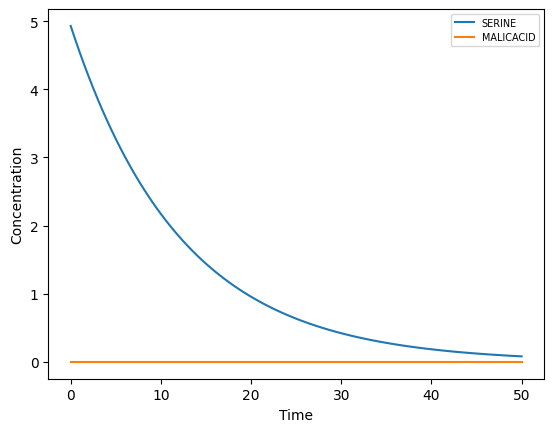

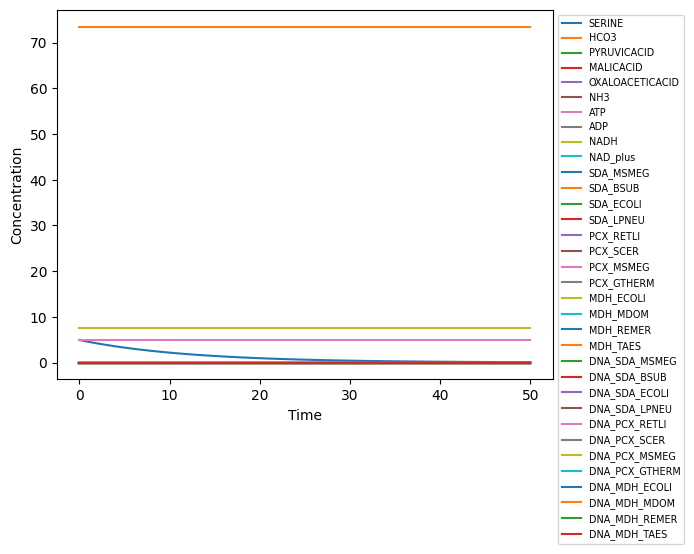

In [12]:
# Extract time and species data
time = df['Time'].values
species_data = df.iloc[:, 1:]

# Specify the subset of species to plot
# This list will have to be generated with the GUI such that each species selected gets appended.
species_list = ['SERINE', 'MALICACID']

#Plots
compare_species_plot(df, species_list)
plot_all(df)

SERINE=4.93095; 

HCO3=7; 

MALICACID=8; 

Successfully converted file 'temp_model.txt' from antimony to SBML and loaded.


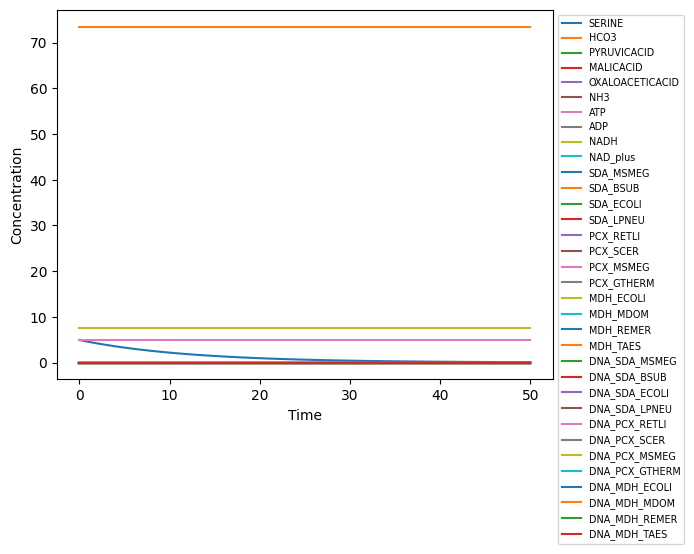

In [13]:
input_file = 'multi_enzyme_model.txt'              # Name of original model to be edited
species_edit = ['SERINE','HCO3', 'MALICACID']      # List of species to be edited, created by user in GUI
new_conc = ['4.93095', '7', '8']                   # New concentrations for each species, assigned by user in GUI

t0 = 0
tf = 50
steps = 101

modify_sim(input_file, species_edit, new_conc)

Successfully converted file 'temp_model.txt' from antimony to SBML and loaded.
Successfully converted file 'temp_model.txt' from antimony to SBML and loaded.
Successfully converted file 'temp_model.txt' from antimony to SBML and loaded.


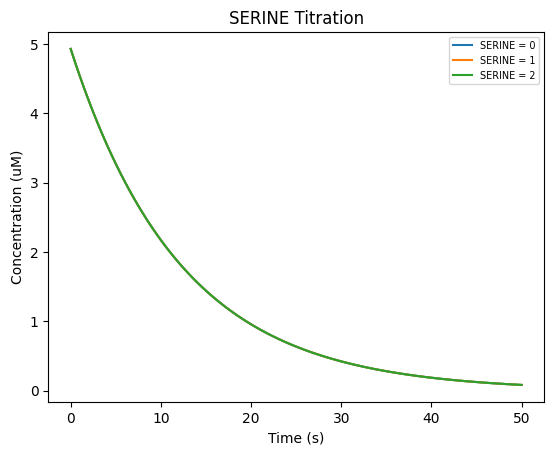

In [14]:
# Input by the user
species = "SERINE"
titration_conc = ['0', '1', '2']

titration_plot('multi_enzyme_model.txt', species, titration_conc)